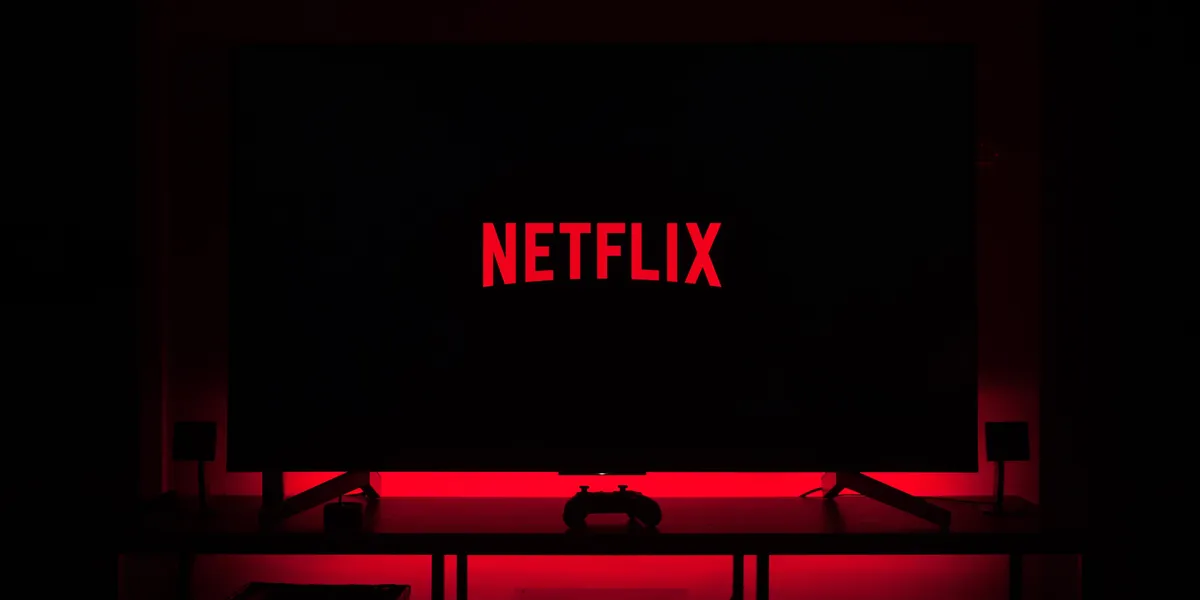

In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly 
import plotly.express as px

In [2]:
netflix = pd.read_csv('netflix_titles.csv')

In [3]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    6137 non-null   object 
 1   title                 6137 non-null   object 
 2   type                  6137 non-null   object 
 3   description           6114 non-null   object 
 4   release_year          6137 non-null   int64  
 5   age_certification     3394 non-null   object 
 6   runtime               6137 non-null   int64  
 7   genres                6137 non-null   object 
 8   production_countries  6137 non-null   object 
 9   seasons               2306 non-null   float64
 10  imdb_id               5741 non-null   object 
 11  imdb_score            5669 non-null   float64
 12  imdb_votes            5653 non-null   float64
 13  tmdb_popularity       6061 non-null   float64
 14  tmdb_score            5885 non-null   float64
dtypes: float64(5), int64(

In [4]:
netflix_df = netflix.copy()

In [41]:
def null_rate_fn(df):
    for i in df.columns:
        null_rate = df[i].isna().sum()/len(df) *100
        if null_rate > 0 :
            print('{} null rate is {}%'.format(i, round(null_rate,2)))

In [42]:
null_rate_fn(netflix_df)

age_certification null rate is 44.7%
imdb_id null rate is 6.45%
imdb_score null rate is 7.63%
imdb_votes null rate is 7.89%
tmdb_popularity null rate is 1.24%
tmdb_score null rate is 4.11%


In [6]:
if len(netflix_df[(netflix_df['type'] == 'MOVIE') & netflix_df['seasons'].isna()]) == netflix_df['seasons'].isna().sum():
    print('1')
else:
    print('0')

1


In [7]:
netflix_df['seasons'] = netflix_df['seasons'].fillna('0')

In [8]:
netflix.head(2)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.601,NaN
1,tm82169,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,"['drama', 'sport']",['US'],NaN,tt0075148,8.1,588100.0,106.361,7.782


In [9]:
netflix_df['primary_genre'] = netflix_df['genres'].apply(lambda x: x.strip("[ ").strip("]").split(",")[0])

In [10]:
netflix_df['primary_genre'] = netflix_df['primary_genre'].str.replace("'", "")

In [11]:
netflix_df['production_country'] = netflix_df['production_countries'].apply(lambda x: x.strip("[ ").strip("]").split(",")[0])

In [12]:
netflix_df['production_country'] = netflix_df['production_country'].str.replace("'", "")

In [13]:
netflix_df.production_country.unique()

array(['US', 'GB', 'EG', 'IN', 'DE', 'CA', 'LB', 'JP', 'AR', '', 'FR',
       'IE', 'AU', 'ET', 'HK', 'MX', 'CN', 'ES', 'CO', 'SU', 'IT', 'TR',
       'NZ', 'DK', 'TW', 'KR', 'RU', 'NG', 'PS', 'MY', 'PH', 'ZA', 'MA',
       'SE', 'SG', 'KE', 'NO', 'CL', 'SA', 'BR', 'ID', 'IS', 'IL', 'PL',
       'FI', 'CD', 'RO', 'AE', 'BE', 'NL', 'UA', 'QA', 'SY', 'GL', 'AT',
       'BY', 'JO', 'VN', 'TN', 'CZ', 'TH', 'GE', 'KH', 'CH', 'CU', 'UY',
       'PE', 'PR', 'KW', 'IR', 'PY', 'PK', 'HU', 'IQ', 'BD', 'TZ', 'CM',
       'KG', 'LU', 'SN', 'BT', 'PT', 'AO', 'GH', 'ZW', 'MW', 'GT', 'MU',
       'IO', 'BG', 'AF', 'DO', 'PA', 'FO'], dtype=object)

In [16]:
import pycountry

In [18]:
abbreviated_countries = netflix_df['production_country']

full_countries = []
for abbreviations in abbreviated_countries:
    country_names = []
    for abbreviation in abbreviations.strip("[]'").split(', '):
        try:
            country = pycountry.countries.get(alpha_2=abbreviation.strip())
            if country is not None:
                country_names.append(country.name)
        except KeyError:
            pass
    full_countries.append(country_names)

In [20]:
netflix_df['country_name'] = full_countries

In [23]:
netflix_df.head(2)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,primary_genre,production_country,country_name
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.601,NaN,documentation,US,[United States]
1,tm82169,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,"['drama', 'sport']",['US'],0,tt0075148,8.1,588100.0,106.361,7.782,drama,US,[United States]


In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [26]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [27]:
example = netflix_df.description[0]

In [28]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.704572, 'roberta_neu': 0.27695864, 'roberta_pos': 0.018469336}


In [29]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [30]:
netflix_df['description'] = netflix_df['description'].astype(str)

In [31]:
res = {}
for i, row in tqdm(netflix_df.iterrows(), total=len(netflix_df)):
    try:
        text = row['description']
        myid = row['id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/6137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id tm33600


In [32]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(netflix_df, how='left')

In [34]:
results_df.head()

,id,roberta_neg,roberta_neu,roberta_pos,title,type,description,release_year,age_certification,runtime,...,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,primary_genre,production_country,country_name
0,ts300399,0.704572,0.276959,0.018469,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,...,['US'],1.0,NaN,NaN,NaN,0.601,NaN,documentation,US,[United States]
1,tm82169,0.210847,0.734630,0.054522,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,...,['US'],0,tt0075148,8.1,588100.0,106.361,7.782,drama,US,[United States]
2,tm17823,0.012765,0.374543,0.612692,Grease,MOVIE,Australian good girl Sandy and greaser Danny f...,1978,PG,110,...,['US'],0,tt0077631,7.2,283316.0,33.160,7.406,romance,US,[United States]
3,tm191099,0.439339,0.534434,0.026227,The Sting,MOVIE,A novice con man teams up with an acknowledged...,1973,PG,129,...,['US'],0,tt0070735,8.3,266738.0,24.616,8.020,crime,US,[United States]
4,tm69975,0.212937,0.720661,0.066402,Rocky II,MOVIE,After Rocky goes the distance with champ Apoll...,1979,PG,119,...,['US'],0,tt0079817,7.3,216307.0,75.699,7.246,drama,US,[United States]


In [35]:
showtime = results_df.copy()

In [37]:
showtime['age_certification'].replace(np.nan, 'No Data', inplace = True)
showtime['production_country'].replace('', 'No Data', inplace = True)
showtime['primary_genre'].replace('', 'No Data', inplace = True)

In [38]:
showtime.head()

,id,roberta_neg,roberta_neu,roberta_pos,title,type,description,release_year,age_certification,runtime,...,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,primary_genre,production_country,country_name
0,ts300399,0.704572,0.276959,0.018469,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,...,['US'],1.0,NaN,NaN,NaN,0.601,NaN,documentation,US,[United States]
1,tm82169,0.210847,0.734630,0.054522,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,...,['US'],0,tt0075148,8.1,588100.0,106.361,7.782,drama,US,[United States]
2,tm17823,0.012765,0.374543,0.612692,Grease,MOVIE,Australian good girl Sandy and greaser Danny f...,1978,PG,110,...,['US'],0,tt0077631,7.2,283316.0,33.160,7.406,romance,US,[United States]
3,tm191099,0.439339,0.534434,0.026227,The Sting,MOVIE,A novice con man teams up with an acknowledged...,1973,PG,129,...,['US'],0,tt0070735,8.3,266738.0,24.616,8.020,crime,US,[United States]
4,tm69975,0.212937,0.720661,0.066402,Rocky II,MOVIE,After Rocky goes the distance with champ Apoll...,1979,PG,119,...,['US'],0,tt0079817,7.3,216307.0,75.699,7.246,drama,US,[United States]


In [43]:
null_rate_fn(showtime)

imdb_id null rate is 6.45%
imdb_score null rate is 7.63%
imdb_votes null rate is 7.89%
tmdb_popularity null rate is 1.24%
tmdb_score null rate is 4.11%


## Done with Data Cleaning

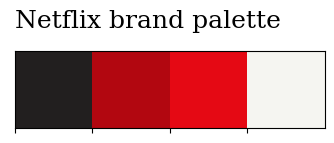

In [47]:
# Palette
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])

plt.title("Netflix brand palette ",loc='left',fontfamily='serif',fontsize=18,y=1.2)
plt.show()

In [50]:
import plotly.graph_objects as go

# Compute the count for each content type
count_data = showtime['type'].value_counts()

# Create a horizontal bar chart
fig = go.Figure(data=go.Bar(
    y=count_data.index,
    x=count_data.values,
    orientation='h',
    marker=dict(color=['#b20710', '#f5f5f1'])
))

# Set title and axis labels
fig.update_layout(
    title='Content on Netflix',
    xaxis_title='Count',
    yaxis_title='Type of Content', title_x = 0.5
)

# Show the plot
fig.show()

In [65]:
showtime.head(2)

,id,roberta_neg,roberta_neu,roberta_pos,title,type,description,release_year,age_certification,runtime,...,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,primary_genre,production_country,country_name
0,ts300399,0.704572,0.276959,0.018469,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,...,['US'],1.0,NaN,NaN,NaN,0.601,NaN,documentation,US,[United States]
1,tm82169,0.210847,0.734630,0.054522,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,...,['US'],0,tt0075148,8.1,588100.0,106.361,7.782,drama,US,[United States]


In [70]:
top_countries = pd.DataFrame(showtime['production_country'].value_counts()[:10])
top_countries = top_countries.reset_index()
top_countries = top_countries[top_countries['index'] != 'No Data']
top_countries

,index,production_country
0,US,2126
1,IN,644
2,GB,306
3,JP,291
4,KR,264
5,ES,200
7,FR,162
8,CA,145
9,MX,132


In [71]:
top_countries = top_countries.rename(columns = {
    'index' : 'production_country',
    'production_country' : 'content_produced'
})
top_countries

,production_country,content_produced
0,US,2126
1,IN,644
2,GB,306
3,JP,291
4,KR,264
5,ES,200
7,FR,162
8,CA,145
9,MX,132


In [73]:
top_countries = top_countries[:5]

In [74]:
fig = px.pie(top_countries, values='content_produced', names='production_country',
             title='Contribution of Content Produced by Top 5 Countries on Netflix')

# Change the color palette
fig.update_traces(marker=dict(colors=['#221f1f', '#b20710', '#e50914','#f5f5f1','#ffffff']))

# Set the text position and information to be displayed
fig.update_traces(textposition='inside', textinfo='percent+label')
# fig.update_traces(title_x = 0.5)


fig.show()

In [75]:
country_order = showtime['production_country'].value_counts()[:11].index
data = showtime[['type', 'production_country']].groupby('production_country')['type'].value_counts().unstack().loc[country_order]
data['sum'] = data.sum(axis=1)
data_ratio = (data.T / data['sum']).T[['MOVIE', 'SHOW']].sort_values(by='MOVIE',ascending=False)[::-1]
data_ratio = data_ratio.reset_index()

In [76]:
data_ratio = data_ratio[data_ratio['index'] != 'No Data']

In [77]:
data_ratio.rename(columns = {'index':'country_code'}, inplace = True)
data_ratio['MOVIE'] = round(data_ratio['MOVIE'], 2)
# data_ratio['MOVIE'] = (data_ratio['MOVIE'] * 100).astype(str) + '%'

In [78]:
data_ratio['SHOW'] = round(data_ratio['SHOW'],2)
data_ratio

type,country_code,MOVIE,SHOW
0,KR,0.19,0.81
1,JP,0.38,0.62
2,GB,0.49,0.51
3,ES,0.58,0.42
4,MX,0.59,0.41
5,FR,0.59,0.41
6,US,0.59,0.41
7,BR,0.60,0.40
8,CA,0.66,0.34
10,IN,0.91,0.09


In [194]:
fig = go.Figure()
# ['#221f1f', '#b20710', '#e50914','#f5f5f1','#ffffff']
# Add horizontal bar traces for MOVIE and SHOW
fig.add_trace(go.Bar(
    y=data_ratio.country_code,
    x=data_ratio['MOVIE'],
    name='MOVIE',
    orientation='h',
    marker=dict(color='#221f1f'),
    text=(data_ratio['MOVIE'] * 100).astype(str) + '%',  # Add text as percentages
    textposition='inside',  # Set text position inside the bars
    textfont=dict(color='white')  # Set text color
))

fig.add_trace(go.Bar(
    y=data_ratio.country_code,
    x=data_ratio['SHOW'],
    name='SHOW',
    orientation='h',
    marker=dict(color='#b20710'),
    text=(data_ratio['SHOW'] * 100).astype(str) + '%',  # Add text as percentages
    textposition='inside',  # Set text position inside the bars
    textfont=dict(color='white')  # Set text color
))

# Set the layout
fig.update_layout(
    title='NETFLIX Content Distribution by Country',
    barmode='stack',
    yaxis_title='Top 10 Countries',
    xaxis=dict(showticklabels=False), title_x = 0.5 # Hide the x-axis tick labels
)

fig.show()

In [94]:
genre_distribution = pd.DataFrame(showtime.groupby('primary_genre')['type'].value_counts())
genre_distribution = genre_distribution.unstack().reset_index().fillna(0).drop(0)
genre_distribution['SUM'] = genre_distribution.sum(axis = 1)

/var/folders/kd/vczjh0f55158sc6lflbyfd4w0000gn/T/ipykernel_63177/3203419532.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [95]:
genre_distribution.columns = ['primary_genre', 'MOVIE', 'SHOW', 'total']

In [96]:
genre_distribution = genre_distribution.sort_values('total', ascending = False)

In [195]:
fig1 = go.Figure()
fig1.add_trace(go.Bar(
    x=genre_distribution['primary_genre'],
    y=genre_distribution['MOVIE'],
    name='MOVIE',
    marker=dict(color='#221f1f'),
))

fig1.add_trace(go.Bar(
    x=genre_distribution['primary_genre'],
    y=genre_distribution['SHOW'],
    name='SHOW',
    marker=dict(color='#b20710'),
))

fig1.update_layout(
    title='Netflix Content Distribution by Genre',
    xaxis_title='Genre',
    yaxis_title='Content on Netflix',
    barmode='stack'
)

fig1.show()

In [102]:
rating_distribution = pd.DataFrame(showtime.groupby('age_certification')['type'].value_counts())
# rating_distribution = genre_distribution.unstack().reset_index().fillna(0).drop(0)
rating_distribution = rating_distribution.unstack().reset_index().fillna(0)
rating_distribution['SUM'] = rating_distribution.sum(axis = 1)
rating_distribution.columns = ['age_certification','MOVIE','SHOW','Total']

/var/folders/kd/vczjh0f55158sc6lflbyfd4w0000gn/T/ipykernel_63177/2154306660.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [104]:
rating_distribution = rating_distribution.sort_values('Total', ascending = False).drop(2)
rating_distribution

,age_certification,MOVIE,SHOW,Total
8,TV-MA,0.0,1018.0,1018.0
5,R,505.0,0.0,505.0
6,TV-14,0.0,493.0,493.0
4,PG-13,449.0,0.0,449.0
3,PG,253.0,0.0,253.0
9,TV-PG,0.0,208.0,208.0
0,G,130.0,0.0,130.0
11,TV-Y7,0.0,127.0,127.0
10,TV-Y,0.0,108.0,108.0
7,TV-G,0.0,85.0,85.0


In [196]:
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=rating_distribution['age_certification'],
    y=rating_distribution['MOVIE'],
    name='MOVIE',
    marker=dict(color='#221f1f'),

))

fig2.add_trace(go.Bar(
    x=rating_distribution['age_certification'],
    y=rating_distribution['SHOW'],
    name='SHOW',
    marker=dict(color='#b20710'),

))

fig2.update_layout(
    title='Content Distribution by Age Rating Certification on Netflix',
    xaxis_title='Genre',
    yaxis_title='Content on Netflix',
    barmode='stack', legend_title = 'Type of Content', title_x = 0.5
)

fig2.show()

In [107]:
history = pd.DataFrame(showtime.groupby('release_year')['type'].value_counts())
history = history.unstack().reset_index().fillna(0)
# history['total'] = history.sum(axis = 1)
history.columns = ['release_year','MOVIE','SHOW']
history = history[(history['release_year'] >= 2000) & (history['release_year'] <= 2021)]

In [197]:
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=history['release_year'],
    y=history['MOVIE'],
    mode='lines',
    name='MOVIE',
    fill='tozeroy',
    line=dict(color='#221f1f')
))

fig3.add_trace(go.Scatter(
    x=history['release_year'],
    y=history['SHOW'],
    mode='lines',
    name='SHOW',
    fill='tozeroy',
    line=dict(color='#b20710')
))

# Set the layout
fig3.update_layout(
    title='Content Trend on Netflix over the Years',
    xaxis_title='Release Year',
    yaxis_title='Content on Netflix', showlegend = False, title_x =0.5
)
fig3.show()

In [109]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

In [110]:
demographic_data = showtime.copy()

In [111]:
demographic_data['target_ages'] = demographic_data['age_certification'].map(ratings_ages)

In [112]:
demographic_data = demographic_data.dropna()

In [113]:
# demographic_data.groupby('production_country','target_ages')[['production_country','target_ages']].sum()
demographic_data = demographic_data.groupby(['production_country', 'target_ages']).size().reset_index(name='count').sort_values('count', ascending = False)[:20]
demographic_data

,production_country,target_ages,count
155,US,Adults,620
158,US,Teens,362
157,US,Older Kids,300
156,US,Kids,126
57,GB,Adults,100
88,JP,Teens,100
47,ES,Adults,75
75,IN,Teens,69
92,KR,Adults,68
95,KR,Teens,68


In [115]:
import plotly.express as px

total_count = demographic_data['count'].sum()
demographic_data['percentage'] = (demographic_data['count'] / total_count) * 100

fig = px.treemap(demographic_data, path=['production_country', 'target_ages'], values='percentage',
                 color='target_ages', color_discrete_sequence= ['#221f1f', '#b20710', '#e50914','#f5f5f1'])

fig.update_layout(title= "Netflix's Country-Level Target Audience",
                  margin=dict(l=20, r=20, t=40, b=20), title_x = 0.5)  # Adjust the margins as needed

fig.show()

In [120]:
demo_genre = showtime.groupby(['production_country', 'primary_genre']).size().reset_index(name='count').sort_values('count', ascending = False)[:20]

In [121]:
demo_genre = demo_genre[demo_genre['production_country']!='No Data']

In [198]:
import plotly.express as px

fig = px.treemap(demo_genre, path=['production_country', 'primary_genre'], values='count', 
                    color_discrete_sequence= ['#221f1f', '#b20710', '#e50914','#f5f5f1']
                 )

# fig = px.treemap(demographic_data, path=['production_country', 'target_ages'], values='percentage',
#                  color='target_ages', color_discrete_sequence= ['#221f1f', '#b20710', '#e50914','#f5f5f1'])

fig.update_layout(title='Netflix Content by Genre and Country',
                  margin=dict(l=20, r=20, t=40, b=20), title_x = 0.5)  # Adjust the margins as needed

fig.show()

In [199]:
fig = px.scatter(showtime, x='imdb_score', y='tmdb_score', color='type',
                 color_discrete_map={'MOVIE': '#221f1f', 'SHOW': '#b20710'},
                 hover_data=['title'])

fig.update_layout(title='IMDb Score vs TMDB Score',
                  xaxis_title='IMDb Score',
                  yaxis_title='TMDB Score',
                  legend_title='Type', title_x =0.5)

fig.show()

In [134]:
sample = showtime.sample(n=1000, random_state=42)

In [172]:
fig = px.scatter(sample, x='roberta_neg', y='roberta_pos', color='type',
                 color_discrete_map={'MOVIE': '#221f1f', 'SHOW': '#b20710'},
                 hover_data=['title'])

fig.update_layout(title='Roberta Negative Score vs Roberta Positive Score',
                  xaxis_title='Roberta Negative Score',
                  yaxis_title='Roberta Positive Score',
                  legend_title='Type', title_x = 0.5)

fig.show()

In [139]:
showtime['sentiment'] = showtime.apply(lambda row: 'Negative' if row['roberta_neg'] > 0.5 else ('Neutral' if row['roberta_neu'] > 0.5 else 'Positive'), axis=1)


In [143]:
sentiment_counts = showtime['sentiment'].value_counts()

# Create the donut chart trace
fig4 = go.Figure(data=[go.Pie(
    labels=sentiment_counts.index,
    values=sentiment_counts.values,
    hole=0.5,  # Set the hole parameter to create a donut chart
    marker=dict(colors=['#221f1f', '#b20710', '#e50914']),  # Set custom colors for the slices
    textinfo='label+percent',  # Display labels and percentages
    textposition='inside',  # Set the position of the labels inside the slice
)])

# Set the layout
fig4.update_layout(
    title='Sentiment Distribution of Content on Netflix',
    showlegend=True, title_x = 0.5, 
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Netflix', x=0.50, y=0.5, font_size=15, showarrow=False)]
)
fig4.show()

In [200]:
fig = px.scatter(showtime, x='imdb_score', y='tmdb_score', color='sentiment',
                 color_discrete_map={'Negative': '#221f1f', 'Neutral': '#b20710', 'Positive': '#e50914'},
                 hover_data=['title'])

fig.update_layout(title='IMDb Score vs TMDB Score',
                  xaxis_title='IMDb Score',
                  yaxis_title='TMDB Score',
                  legend_title='Type', title_x = 0.5)

fig.show()

In [146]:
genre_sentiment = showtime.groupby(['primary_genre', 'sentiment']).size().reset_index(name='count')
genre_sentiment = genre_sentiment[genre_sentiment['primary_genre']!= 'No Data']
genre_sentiment = genre_sentiment.sort_values('count', ascending = False)

In [201]:
colors = ['#221f1f', '#b20710', '#e50914','#f5f5f1']

fig = px.sunburst(genre_sentiment, path=['primary_genre', 'sentiment'], values='count',
                  color_discrete_sequence=colors)

fig.update_layout(title='Genre vs Sentiments on Netflix', title_x = 0.5)

fig.show()

In [149]:
age_certificate_sentiment = showtime.groupby(['age_certification', 'sentiment']).size().reset_index(name='count')
age_certificate_sentiment = age_certificate_sentiment[age_certificate_sentiment['age_certification']!= 'No Data']
age_certificate_sentiment = age_certificate_sentiment.sort_values('count', ascending = False)

In [202]:
fig = px.sunburst(age_certificate_sentiment, path=['age_certification', 'sentiment'], values='count',
                  color_discrete_sequence=colors)

fig.update_layout(title='Rating vs Sentiments on Netflix', title_x = 0.5)

fig.show()

In [ ]:
filter_showtime = showtime[(showtime['release_year'] >= 2010) & (showtime['release_year'] <= 2020)]

filter_showtime = filter_showtime.groupby(['release_year', 'sentiment']).size().reset_index(name='count')

colors = ['#221f1f', '#b20710', '#e50914','#f5f5f1']

fig = px.area(filter_showtime, x='release_year', y='count', color='sentiment',
              color_discrete_sequence=colors,
              title='Trend of Content Released on Netflix Over Time')

# Set the layout
fig.update_layout(
    xaxis_title='Release Year',
    yaxis_title='Content Produced',
    legend_title='Sentiment', title_x = 0.5
)
fig.show()

In [152]:
showtime['title'] = showtime['title'].astype(str)
title_corpus = ' '.join(showtime['title'])

In [153]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image #to load our image

In [154]:
stopwords = set(STOPWORDS)

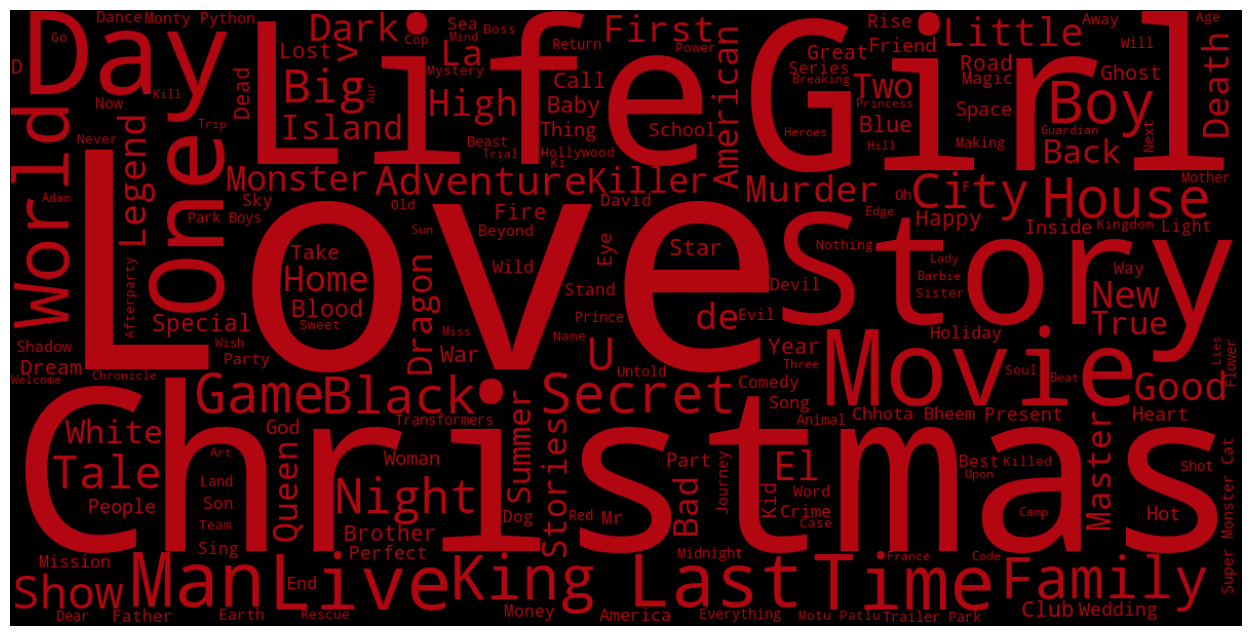

In [173]:
# Define a function to specify the text color
def netflix_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#b20710"

custom_mask = np.array(Image.open('logo2.jpg.webp')) 
wc = WordCloud(
               stopwords = stopwords,
               mask = custom_mask,height = 2000, width = 4000, color_func = netflix_color)
#background_color = 'white',
wc.generate(title_corpus)

plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [174]:
showtime.head(2)

,id,roberta_neg,roberta_neu,roberta_pos,title,type,description,release_year,age_certification,runtime,...,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,primary_genre,production_country,country_name,sentiment
0,ts300399,0.704572,0.276959,0.018469,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,...,1.0,NaN,NaN,NaN,0.601,NaN,documentation,US,[United States],Negative
1,tm82169,0.210847,0.734630,0.054522,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,...,0,tt0075148,8.1,588100.0,106.361,7.782,drama,US,[United States],Neutral


In [175]:
numeric_columns = showtime.select_dtypes(include=[int, float])
numeric_columns

,roberta_neg,roberta_neu,roberta_pos,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,0.704572,0.276959,0.018469,1945,51,NaN,NaN,0.601,NaN
1,0.210847,0.734630,0.054522,1976,119,8.1,588100.0,106.361,7.782
2,0.012765,0.374543,0.612692,1978,110,7.2,283316.0,33.160,7.406
3,0.439339,0.534434,0.026227,1973,129,8.3,266738.0,24.616,8.020
4,0.212937,0.720661,0.066402,1979,119,7.3,216307.0,75.699,7.246
...,...,...,...,...,...,...,...,...,...
6131,0.292726,0.664152,0.043122,2023,81,NaN,NaN,3.351,2.000
6132,0.009413,0.539437,0.451150,2023,120,7.9,209.0,2.450,7.200
6133,0.291384,0.452020,0.256596,2023,69,6.1,91.0,1.960,NaN
6134,0.900442,0.096677,0.002881,2023,80,5.2,18.0,1.357,4.000


In [177]:
colors = ['#221f1f', '#b20710', '#e50914','#f5f5f1']

fig = px.histogram(showtime, x='runtime', color_discrete_sequence=colors)

# Customize the layout if needed
fig.update_layout(
    title='Runtime Distribution of Content on Netflix',
    xaxis_title='Runtime',
    yaxis_title='Count of Content', title_x = 0.5, bargap=0.2
)

fig.show()

In [184]:
colors = ['#221f1f', '#b20710', '#e50914','#f5f5f1']

fig = px.histogram(showtime, x='seasons', color_discrete_sequence=colors, nbins = 5)

# Customize the layout if needed
fig.update_layout(
    title='Season Distribution of Content on Netflix',
    xaxis_title='Number of Seasons',
    yaxis_title='Count of Content', title_x = 0.5, bargap=0.2
)

fig.show()

In [179]:
colors = ['#221f1f', '#b20710', '#e50914','#f5f5f1']

fig = px.histogram(showtime, x='imdb_score', color_discrete_sequence=colors)

# Customize the layout if needed
fig.update_layout(
    title='IMDB Score Distribution of Content on Netflix',
    xaxis_title='IMDB Score',
    yaxis_title='Count of Content', title_x = 0.5, bargap=0.2
)

fig.show()

In [180]:
colors = ['#221f1f', '#b20710', '#e50914','#f5f5f1']

fig = px.histogram(showtime, x='tmdb_score', color_discrete_sequence=colors)

# Customize the layout if needed
fig.update_layout(
    title='TMDB Score Distribution of Content on Netflix',
    xaxis_title='TMDB Score',
    yaxis_title='Count of Content', title_x = 0.5, bargap=0.2
)

fig.show()

In [187]:
netflix_credits = pd.read_csv('netflix_credits.csv')

In [188]:
netflix_credits.head()

,person_id,id,name,character,role
0,3180,tm82169,Sylvester Stallone,"Robert ""Rocky"" Balboa",ACTOR
1,7748,tm82169,Talia Shire,"Adrianna ""Adrian"" Pennino",ACTOR
2,7749,tm82169,Burt Young,Paulie Pennino,ACTOR
3,7750,tm82169,Carl Weathers,Apollo Creed,ACTOR
4,7751,tm82169,Burgess Meredith,Mickey Goldmill,ACTOR


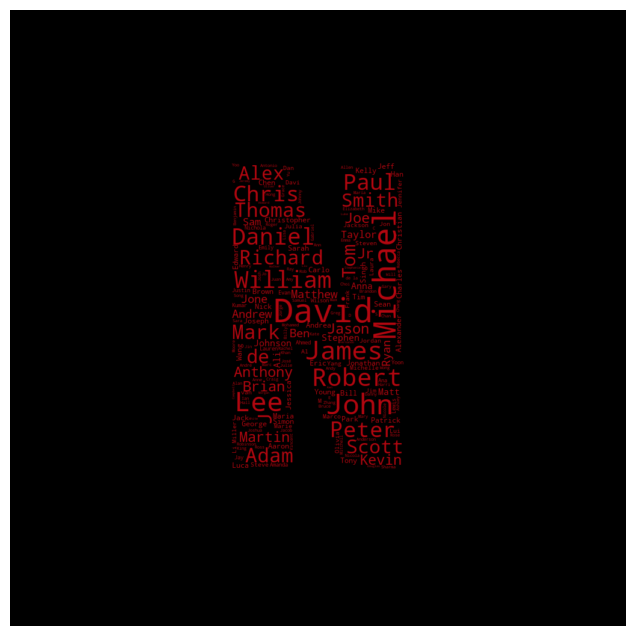

In [191]:
# most popular actor on amazon prime
netflix_credits['name'] = netflix_credits['name'].astype(str)
name_corpus = ' '.join(netflix_credits['name'])

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image #to load our image
stopwords = set(STOPWORDS)

# Define a function to specify the text color
def netflix_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#b20710"

custom_mask = np.array(Image.open('net2.jpg.webp')) 
wc = WordCloud(
               stopwords = stopwords,
               mask = custom_mask,height = 2000, width = 4000, color_func = netflix_color)
#background_color = 'white',
wc.generate(name_corpus)

plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()